## Prerequisite Packages

In [73]:
# Based on https://www.tensorflow.org/datasets/keras_example
# use pip install <package> to find any packages that are missing
import keras         # for fitting DNNs
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

## We split the data into training and testing

In [74]:
(ds_train,ds_val, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train[:80%]','train[80%:]','test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)


## Functions: normalizing images, and returning labels/images

In [75]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label
def get_label(image,label):
    return label
def get_image(image,label):
    return image


## We apply these functions to extract model-ready data

In [76]:
# this just normalizes the image
ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# cache and prefetch save memory 
ds_train = ds_train.cache()
# we shuffle data (reduces effects of order when training model)
ds_train = ds_train.shuffle(ds_info.splits['train[:80%]'].num_examples)
# batch size tells us how many samples are needed for stochastic gradient descent 
# (a small number like 32 is empirically found to be better)
ds_train = ds_train.batch(32)# batch of 32   
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)


ds_val = ds_val.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_val = ds_val.cache()  #store and memtory >> Need to use cache if we don't want to get error
ds_val = ds_val.shuffle(ds_info.splits['train[80%:]'].num_examples)  #shuffle
ds_val = ds_val.batch(32)# batch of 32    
ds_val = ds_val.prefetch(tf.data.experimental.AUTOTUNE) #Need to use prefetch if we don't want to get error 

#cache & prefetch: store dataset into memory, so can quickly train the model

ds_test_label=ds_test.map(
    get_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test_images=ds_test.map(
    get_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

ds_test = ds_test.batch(32)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.experimental.AUTOTUNE)


## Model training

In [82]:

from keras import backend as K

dense=False
if dense:
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(56,activation='relu'),
    tf.keras.layers.Dropout(.2, input_shape=(56,)),
      tf.keras.layers.Dense(24,activation='relu'),
      tf.keras.layers.Dense(10)
    ])
else:
    model = tf.keras.models.Sequential([])
    model.add(tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1))) 
    #kernal_size = 3: how many filter/weight we use, 'relu': BEST image activation
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
    model.add(tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu'))
    #model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Dropout(.45))
    #model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2),strides=(1, 1), padding='valid'))
    model.add(tf.keras.layers.Flatten())
    #model.add(tf.keras.layers.BatchNormalization())
    #tf.keras.layers.Dense(24,activation='relu'),
    model.add(tf.keras.layers.Dense(10))  #0,1,2,3,4,5,6,7,8,9

model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

history=model.fit(
    ds_train,
    epochs=30,
    callbacks=my_callbacks,
    validation_data=ds_val
)


Epoch 1/30
1500/1500 [==============================] - 112s 75ms/step - loss: 0.3262 - sparse_categorical_accuracy: 0.8978 - val_loss: 0.0659 - val_sparse_categorical_accuracy: 0.9800
Epoch 2/30
1500/1500 [==============================] - 113s 75ms/step - loss: 0.0695 - sparse_categorical_accuracy: 0.9774 - val_loss: 0.0480 - val_sparse_categorical_accuracy: 0.9845
Epoch 3/30
1500/1500 [==============================] - 108s 72ms/step - loss: 0.0488 - sparse_categorical_accuracy: 0.9846 - val_loss: 0.0458 - val_sparse_categorical_accuracy: 0.9858
Epoch 4/30
1500/1500 [==============================] - 105s 70ms/step - loss: 0.0410 - sparse_categorical_accuracy: 0.9866 - val_loss: 0.0388 - val_sparse_categorical_accuracy: 0.9883
Epoch 5/30
1500/1500 [==============================] - 107s 71ms/step - loss: 0.0336 - sparse_categorical_accuracy: 0.9893 - val_loss: 0.0437 - val_sparse_categorical_accuracy: 0.9865


In [83]:
50000/32

1562.5

## Here we check the accuracy in the held-out test dataset

In [84]:
gt_labels=list(ds_test_label)
predictions=[np.argmax(im) for im in model.predict(ds_test)]
accuracy_score(predictions,gt_labels)

0.9883

## How does loss in training/validation vary with epoch?

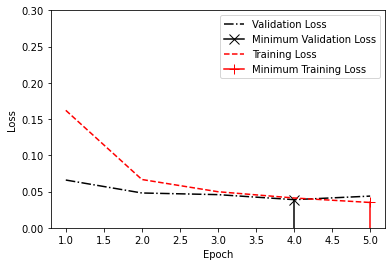

In [85]:
# These definitions make the plot code easier to read
minvalx=np.argmin(history.history['val_loss'])+1
minvaly=min(history.history['val_loss'])
mintrainx=np.argmin(history.history['loss'])+1
mintrainy=min(history.history['loss'])
lowpoint_val=np.array([[minvalx,-10],[minvalx,minvaly]])
lowpoint_train=np.array([[mintrainx,-10],[mintrainx,mintrainy]])

# N.B., it's always good to label axes and lines
plt.plot(list(range(1,len(history.history['val_loss'])+1)),history.history['val_loss'],'k-.',label='Validation Loss')
plt.plot(lowpoint_val[:,0],lowpoint_val[:,1],'kx-',markersize=10,label='Minimum Validation Loss')
plt.plot(list(range(1,len(history.history['loss'])+1)),history.history['loss'],'r--',label='Training Loss')
plt.plot(lowpoint_train[:,0],lowpoint_train[:,1],'r+-',markersize=10,label='Minimum Training Loss')
# creates legend from "label" attribute
plt.legend()
# y limit
plt.ylim([0,0.3])
# axes labels
plt.ylabel('Loss')
plt.xlabel('Epoch')
# show the plot
# to save figure, you can use plt.savefig(<file name>)
plt.show()
